In [30]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict, Counter
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

@dataclass
class SystemConfig:
    device: str = "cpu"
    model_name: str = "hybrid_deer_model"
    max_length: int = 256
    batch_size: int = 1
    num_demonstrations: int = 5
    temperature: float = 0.7
    top_p: float = 0.9

class DataLoader:
    @staticmethod
    def load_conll_style_data():
        train_data = [
            {
                "tokens": ["Apple", "Inc.", "was", "founded", "by", "Steve", "Jobs", "in", "Cupertino"],
                "labels": ["B-ORG", "I-ORG", "O", "O", "O", "B-PER", "I-PER", "O", "B-LOC"]
            },
            {
                "tokens": ["Microsoft", "Corporation", "announced", "new", "products", "in", "Seattle"],
                "labels": ["B-ORG", "I-ORG", "O", "O", "O", "O", "B-LOC"]
            },
            {
                "tokens": ["Barack", "Obama", "visited", "Germany", "last", "week"],
                "labels": ["B-PER", "I-PER", "O", "B-LOC", "O", "O"]
            },
            {
                "tokens": ["The", "United", "Nations", "held", "a", "conference", "in", "New", "York"],
                "labels": ["O", "B-ORG", "I-ORG", "O", "O", "O", "O", "B-LOC", "I-LOC"]
            },
            {
                "tokens": ["Tesla", "CEO", "Elon", "Musk", "spoke", "at", "the", "event"],
                "labels": ["B-ORG", "O", "B-PER", "I-PER", "O", "O", "O", "O"]
            },
            {
                "tokens": ["Google", "headquarters", "are", "located", "in", "Mountain", "View"],
                "labels": ["B-ORG", "O", "O", "O", "O", "B-LOC", "I-LOC"]
            },
            {
                "tokens": ["Amazon", "Web", "Services", "opened", "office", "in", "London"],
                "labels": ["B-ORG", "I-ORG", "I-ORG", "O", "O", "O", "B-LOC"]
            },
            {
                "tokens": ["Bill", "Gates", "founded", "Microsoft", "in", "1975"],
                "labels": ["B-PER", "I-PER", "O", "B-ORG", "O", "O"]
            },
            {
                "tokens": ["Facebook", "acquired", "Instagram", "for", "$1", "billion"],
                "labels": ["B-ORG", "O", "B-ORG", "O", "O", "O"]
            },
            {
                "tokens": ["Tim", "Cook", "is", "the", "CEO", "of", "Apple"],
                "labels": ["B-PER", "I-PER", "O", "O", "O", "O", "B-ORG"]
            },
            {
                "tokens": ["SpaceX", "launched", "Falcon", "9", "from", "Cape", "Canaveral"],
                "labels": ["B-ORG", "O", "O", "O", "O", "B-LOC", "I-LOC"]
            },
            {
                "tokens": ["Angela", "Merkel", "met", "Emmanuel", "Macron", "in", "Paris"],
                "labels": ["B-PER", "I-PER", "O", "B-PER", "I-PER", "O", "B-LOC"]
            },
            {
                "tokens": ["IBM", "Watson", "uses", "artificial", "intelligence"],
                "labels": ["B-ORG", "I-ORG", "O", "O", "O"]
            },
            {
                "tokens": ["Jeff", "Bezos", "stepped", "down", "as", "Amazon", "CEO"],
                "labels": ["B-PER", "I-PER", "O", "O", "O", "B-ORG", "O"]
            },
            {
                "tokens": ["The", "European", "Union", "passed", "new", "regulations"],
                "labels": ["O", "B-ORG", "I-ORG", "O", "O", "O"]
            }
        ]

        test_data = [
            {
                "tokens": ["Netflix", "expanded", "operations", "to", "Asia"],
                "labels": ["B-ORG", "O", "O", "O", "B-LOC"]
            },
            {
                "tokens": ["Warren", "Buffett", "invested", "in", "Apple", "stocks"],
                "labels": ["B-PER", "I-PER", "O", "O", "B-ORG", "O"]
            },
            {
                "tokens": ["Toyota", "announced", "factory", "in", "Texas"],
                "labels": ["B-ORG", "O", "O", "O", "B-LOC"]
            },
            {
                "tokens": ["Mark", "Zuckerberg", "founded", "Facebook", "at", "Harvard"],
                "labels": ["B-PER", "I-PER", "O", "B-ORG", "O", "B-ORG"]
            },
            {
                "tokens": ["Samsung", "Electronics", "headquarters", "in", "Seoul"],
                "labels": ["B-ORG", "I-ORG", "O", "O", "B-LOC"]
            },
            {
                "tokens": ["Joe", "Biden", "visited", "Ukraine", "yesterday"],
                "labels": ["B-PER", "I-PER", "O", "B-LOC", "O"]
            },
            {
                "tokens": ["OpenAI", "released", "ChatGPT", "last", "year"],
                "labels": ["B-ORG", "O", "B-ORG", "O", "O"]
            },
            {
                "tokens": ["London", "Stock", "Exchange", "closed", "higher"],
                "labels": ["B-ORG", "I-ORG", "I-ORG", "O", "O"]
            }
        ]

        train_data = train_data * 3

        return train_data, test_data

class LabelGuidedSelector:

    def __init__(self, train_data: List[Dict]):
        self.train_data = train_data
        self.label_index = self._build_label_index()
        self.entity_type_index = self._build_entity_type_index()

    def _build_label_index(self) -> Dict[str, List[int]]:
        label_index = defaultdict(list)
        for idx, sample in enumerate(self.train_data):
            unique_labels = set(sample["labels"])
            for label in unique_labels:
                if label != "O":
                    label_index[label].append(idx)
        return label_index

    def _build_entity_type_index(self) -> Dict[str, List[int]]:
        entity_index = defaultdict(list)
        for idx, sample in enumerate(self.train_data):
            entity_types = set()
            for label in sample["labels"]:
                if label != "O":
                    entity_type = label.split("-")[1]
                    entity_types.add(entity_type)
            for entity_type in entity_types:
                entity_index[entity_type].append(idx)
        return entity_index

    def select_demonstrations(self, query_sample: Dict, k: int = 5) -> List[Dict]:
        query_labels = set(query_sample.get("labels", []))
        query_labels.discard("O")

        query_entity_types = set()
        for label in query_labels:
            if label != "O":
                query_entity_types.add(label.split("-")[1])

        relevance_scores = []
        for idx, sample in enumerate(self.train_data):
            sample_labels = set(sample["labels"])
            sample_labels.discard("O")

            exact_match = len(query_labels.intersection(sample_labels))

            sample_entity_types = set()
            for label in sample_labels:
                if label != "O":
                    sample_entity_types.add(label.split("-")[1])
            type_match = len(query_entity_types.intersection(sample_entity_types))

            score = exact_match * 2 + type_match + random.random() * 0.1

            if len(sample_labels) > 2:
                score += 0.5

            relevance_scores.append((idx, score))

        relevance_scores.sort(key=lambda x: x[1], reverse=True)

        selected_indices = []
        selected_labels_set = set()

        for idx, score in relevance_scores:
            if len(selected_indices) >= k:
                break

            sample_labels = set(self.train_data[idx]["labels"])
            if not sample_labels.issubset(selected_labels_set) or len(selected_indices) < k//2:
                selected_indices.append(idx)
                selected_labels_set.update(sample_labels)

        return [self.train_data[idx] for idx in selected_indices]

class DEERPromptBuilder:

    def __init__(self):
        self.label_descriptions = {
            "B-PER": "Beginning of person name",
            "I-PER": "Inside person name",
            "B-ORG": "Beginning of organization",
            "I-ORG": "Inside organization",
            "B-LOC": "Beginning of location",
            "I-LOC": "Inside location",
            "O": "Not an entity"
        }

    def build_prompt(self, demonstrations: List[Dict], query: Dict) -> str:
        prompt_parts = []

        prompt_parts.append("Task: Named Entity Recognition\n")
        prompt_parts.append("Identify and label person names (PER), organizations (ORG), and locations (LOC).\n\n")

        prompt_parts.append("Label definitions:\n")
        for label, desc in self.label_descriptions.items():
            prompt_parts.append(f"  {label}: {desc}\n")
        prompt_parts.append("\n")

        prompt_parts.append("Examples:\n")
        for i, demo in enumerate(demonstrations, 1):
            prompt_parts.append(f"\nExample {i}:\n")
            prompt_parts.append(f"  Text: {' '.join(demo['tokens'])}\n")
            prompt_parts.append(f"  Labels: {' '.join(demo['labels'])}\n")

        prompt_parts.append("\nNow label this text:\n")
        prompt_parts.append(f"  Text: {' '.join(query['tokens'])}\n")
        prompt_parts.append("  Labels: ")

        return "".join(prompt_parts)

class HybridDEERModel:

    def __init__(self, config: SystemConfig):
        self.config = config

        self.knowledge_base = {
            'person_first': {'steve', 'bill', 'elon', 'jeff', 'tim', 'mark', 'barack',
                            'angela', 'emmanuel', 'warren', 'joe', 'donald'},
            'person_last': {'jobs', 'gates', 'musk', 'bezos', 'cook', 'zuckerberg',
                           'obama', 'merkel', 'macron', 'buffett', 'biden', 'trump'},
            'organizations': {'apple', 'microsoft', 'google', 'amazon', 'tesla', 'spacex',
                            'facebook', 'netflix', 'ibm', 'samsung', 'toyota', 'openai',
                            'united nations', 'european union', 'harvard', 'chatgpt'},
            'locations': {'cupertino', 'seattle', 'germany', 'new york', 'mountain view',
                         'london', 'paris', 'texas', 'asia', 'seoul', 'ukraine', 'cape canaveral'},
            'org_suffixes': {'inc', 'corp', 'corporation', 'ltd', 'llc', 'company',
                           'services', 'electronics', 'exchange'},
            'location_indicators': {'in', 'at', 'from', 'to', 'near', 'visited'}
        }

        self.demo_statistics = defaultdict(lambda: defaultdict(int))
        self.context_patterns = defaultdict(lambda: defaultdict(int))

    def learn_from_demonstrations(self, demonstrations: List[Dict]):
        for demo in demonstrations:
            tokens = demo['tokens']
            labels = demo['labels']

            for i, (token, label) in enumerate(zip(tokens, labels)):
                self.demo_statistics[token.lower()][label] += 1

                if i > 0:
                    prev_token = tokens[i-1].lower()
                    self.context_patterns[f"after_{prev_token}"][label] += 1

                if i > 0 and labels[i-1] != "O":
                    self.context_patterns[f"follows_{labels[i-1]}"][label] += 1

    def extract_demonstrations_from_prompt(self, prompt: str) -> List[Dict]:
        demonstrations = []
        lines = prompt.split('\n')

        i = 0
        while i < len(lines):
            if 'Text:' in lines[i]:
                tokens = lines[i].split('Text:')[1].strip().split()
                if i + 1 < len(lines) and 'Labels:' in lines[i + 1]:
                    labels = lines[i + 1].split('Labels:')[1].strip().split()
                    if len(labels) == len(tokens):
                        demonstrations.append({'tokens': tokens, 'labels': labels})
                i += 2
            else:
                i += 1

        return demonstrations

    def apply_rules(self, token: str, prev_token: str, next_token: str,
                   prev_label: str) -> str:
        token_lower = token.lower()

        if token_lower in self.knowledge_base['person_first']:
            return "B-PER"
        if token_lower in self.knowledge_base['person_last'] and prev_label == "B-PER":
            return "I-PER"

        if token_lower in self.knowledge_base['organizations']:
            return "B-ORG"
        if token_lower in self.knowledge_base['org_suffixes'] and prev_label in ["B-ORG"]:
            return "I-ORG"

        if token_lower in self.knowledge_base['locations']:
            return "B-LOC"

        if prev_token in self.knowledge_base['location_indicators'] and token[0].isupper():
            return "B-LOC"

        if token[0].isupper() and prev_label in ["B-PER", "B-ORG", "B-LOC"]:
            entity_type = prev_label.split("-")[1]
            if len(token) > 1 and not token.lower() in ['the', 'a', 'an', 'of', 'in', 'at']:
                return f"I-{entity_type}"

        return None

    def generate_labels(self, prompt: str, query_tokens: List[str]) -> List[str]:
        demonstrations = self.extract_demonstrations_from_prompt(prompt)
        if demonstrations:
            self.learn_from_demonstrations(demonstrations)

        predicted_labels = []

        for i, token in enumerate(query_tokens):
            token_lower = token.lower()
            prev_token = query_tokens[i-1].lower() if i > 0 else ""
            next_token = query_tokens[i+1].lower() if i < len(query_tokens)-1 else ""
            prev_label = predicted_labels[-1] if predicted_labels else "O"

            if token_lower in self.demo_statistics:
                label_counts = self.demo_statistics[token_lower]
                if label_counts:
                    predicted_label = max(label_counts, key=label_counts.get)
                    if predicted_label.startswith("I-") and not prev_label.startswith("B-"):
                        predicted_label = predicted_label.replace("I-", "B-")
                    predicted_labels.append(predicted_label)
                    continue

            rule_label = self.apply_rules(token, prev_token, next_token, prev_label)
            if rule_label:
                predicted_labels.append(rule_label)
                continue

            if prev_token:
                context_key = f"after_{prev_token}"
                if context_key in self.context_patterns:
                    pattern_labels = self.context_patterns[context_key]
                    if pattern_labels:
                        predicted_label = max(pattern_labels, key=pattern_labels.get)
                        predicted_labels.append(predicted_label)
                        continue

            if token[0].isupper() and len(token) > 1:
                if prev_label != "O" and prev_label.startswith("B-"):
                    entity_type = prev_label.split("-")[1]
                    predicted_labels.append(f"I-{entity_type}")
                elif i < len(query_tokens) - 1 and query_tokens[i+1][0].isupper():
                    predicted_labels.append("B-PER")
                else:
                    predicted_labels.append("O")
            else:
                predicted_labels.append("O")

        self._postprocess_labels(predicted_labels)

        return predicted_labels

    def _postprocess_labels(self, labels: List[str]):
        for i in range(len(labels)):
            if labels[i].startswith("I-"):
                if i == 0 or labels[i-1] == "O":
                    labels[i] = labels[i].replace("I-", "B-")
                elif i > 0:
                    prev_type = labels[i-1].split("-")[1] if "-" in labels[i-1] else None
                    curr_type = labels[i].split("-")[1]
                    if prev_type != curr_type:
                        labels[i] = f"B-{curr_type}"

class DEERPipeline:

    def __init__(self, config: SystemConfig):
        self.config = config
        self.model = HybridDEERModel(config)
        self.prompt_builder = DEERPromptBuilder()
        self.selector = None

    def train(self, train_data: List[Dict]):
        self.selector = LabelGuidedSelector(train_data)
        print(f"Селектор инициализирован с {len(train_data)} примерами")

    def predict(self, test_sample: Dict) -> List[str]:
        demonstrations = self.selector.select_demonstrations(
            test_sample,
            k=self.config.num_demonstrations
        )
        prompt = self.prompt_builder.build_prompt(demonstrations, test_sample)
        predicted_labels = self.model.generate_labels(prompt, test_sample["tokens"])

        num_tokens = len(test_sample["tokens"])
        if len(predicted_labels) < num_tokens:
            predicted_labels.extend(["O"] * (num_tokens - len(predicted_labels)))
        elif len(predicted_labels) > num_tokens:
            predicted_labels = predicted_labels[:num_tokens]

        return predicted_labels

    def evaluate(self, test_data: List[Dict]) -> Tuple[Dict, List[str], List[str]]:
        all_true = []
        all_pred = []

        for sample in tqdm(test_data, desc="Оценка модели"):
            pred_labels = self.predict(sample)
            all_true.extend(sample["labels"])
            all_pred.extend(pred_labels)

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_true, all_pred, average='weighted', zero_division=0
        )

        class_report = classification_report(
            all_true, all_pred, output_dict=True, zero_division=0
        )

        metrics = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "class_report": class_report
        }

        return metrics, all_true, all_pred

In [31]:
def create_comprehensive_visualizations(metrics, true_labels, pred_labels, train_data, test_data):
    fig = plt.figure(figsize=(18, 12))

    ax1 = plt.subplot(3, 3, 1)
    metrics_vals = [metrics['precision'], metrics['recall'], metrics['f1_score']]
    metrics_names = ['Precision', 'Recall', 'F1-Score']
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    bars = ax1.bar(metrics_names, metrics_vals, color=colors)
    ax1.set_ylim([0, 1])
    ax1.set_title('Основные метрики производительности', fontweight='bold')
    ax1.set_ylabel('Значение')
    ax1.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars, metrics_vals):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    ax2 = plt.subplot(3, 3, 2)
    class_results = []
    for cls, vals in metrics["class_report"].items():
        if cls not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(vals, dict):
            class_results.append({
                "entity": cls,
                "f1": vals.get('f1-score', 0),
                "support": vals.get('support', 0)
            })

    if class_results:
        entities = [r['entity'] for r in class_results]
        f1_scores = [r['f1'] for r in class_results]
        ax2.barh(entities, f1_scores, color='#9b59b6')
        ax2.set_xlim([0, 1])
        ax2.set_xlabel('F1-Score')
        ax2.set_title('F1-метрика по типам сущностей', fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)

        for i, (e, f) in enumerate(zip(entities, f1_scores)):
            ax2.text(f + 0.02, i, f'{f:.3f}', va='center')

    ax3 = plt.subplot(3, 3, 3)
    baseline_f1 = 0.15
    deer_f1 = metrics['f1_score']
    comparison_vals = [baseline_f1, deer_f1]
    comparison_names = ['Random\nBaseline', 'DEER\nModel']
    colors_comp = ['#95a5a6', '#27ae60'] if deer_f1 > baseline_f1 else ['#95a5a6', '#e74c3c']
    bars = ax3.bar(comparison_names, comparison_vals, color=colors_comp)
    ax3.set_ylim([0, 1])
    ax3.set_title('Сравнение с базовой моделью', fontweight='bold')
    ax3.set_ylabel('F1-Score')
    ax3.grid(axis='y', alpha=0.3)

    improvement = ((deer_f1 - baseline_f1) / baseline_f1) * 100
    ax3.text(0.5, 0.9, f'Улучшение: {improvement:.1f}%',
            transform=ax3.transAxes, ha='center', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    for bar, val in zip(bars, comparison_vals):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    ax4 = plt.subplot(3, 3, 4)
    unique_labels = sorted(list(set(true_labels + pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=unique_labels, yticklabels=unique_labels, ax=ax4,
               cbar_kws={'shrink': 0.8})
    ax4.set_xlabel('Предсказано')
    ax4.set_ylabel('Истинно')
    ax4.set_title('Матрица ошибок', fontweight='bold')

    ax5 = plt.subplot(3, 3, 5)
    train_label_counts = Counter()
    for sample in train_data:
        train_label_counts.update(sample["labels"])

    labels = list(train_label_counts.keys())
    counts = list(train_label_counts.values())
    sorted_indices = np.argsort(counts)[::-1]
    labels = [labels[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    ax5.bar(labels, counts, color='#3498db', alpha=0.7)
    ax5.set_title('Распределение меток (обучение)', fontweight='bold')
    ax5.set_xlabel('Метка')
    ax5.set_ylabel('Количество')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(axis='y', alpha=0.3)

    ax6 = plt.subplot(3, 3, 6)
    test_label_counts = Counter()
    for sample in test_data:
        test_label_counts.update(sample["labels"])

    labels_test = list(test_label_counts.keys())
    counts_test = list(test_label_counts.values())
    sorted_indices = np.argsort(counts_test)[::-1]
    labels_test = [labels_test[i] for i in sorted_indices]
    counts_test = [counts_test[i] for i in sorted_indices]

    ax6.bar(labels_test, counts_test, color='#e74c3c', alpha=0.7)
    ax6.set_title('Распределение меток (тест)', fontweight='bold')
    ax6.set_xlabel('Метка')
    ax6.set_ylabel('Количество')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(axis='y', alpha=0.3)

    ax7 = plt.subplot(3, 3, 7)
    if class_results:
        precisions = []
        recalls = []
        entity_names = []

        for cls, vals in metrics["class_report"].items():
            if cls not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(vals, dict):
                precisions.append(vals.get('precision', 0))
                recalls.append(vals.get('recall', 0))
                entity_names.append(cls)

        scatter = ax7.scatter(recalls, precisions, s=100, alpha=0.6, c=range(len(entity_names)), cmap='viridis')

        for i, txt in enumerate(entity_names):
            ax7.annotate(txt, (recalls[i], precisions[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

        ax7.set_xlabel('Recall')
        ax7.set_ylabel('Precision')
        ax7.set_title('Precision vs Recall', fontweight='bold')
        ax7.set_xlim([0, 1])
        ax7.set_ylim([0, 1])
        ax7.grid(True, alpha=0.3)
        ax7.plot([0, 1], [0, 1], 'k--', alpha=0.3)

    ax8 = plt.subplot(3, 3, 8)
    entity_types = {'PER': 0, 'ORG': 0, 'LOC': 0}
    for label in true_labels:
        if label != 'O' and '-' in label:
            entity_type = label.split('-')[1]
            if entity_type in entity_types:
                entity_types[entity_type] += 1

    ax8.pie(entity_types.values(), labels=entity_types.keys(), autopct='%1.1f%%',
           colors=['#ff9999', '#66b3ff', '#99ff99'])
    ax8.set_title('Распределение типов сущностей', fontweight='bold')

    ax9 = plt.subplot(3, 3, 9)
    sequence_lengths = [len(sample['tokens']) for sample in test_data]
    ax9.hist(sequence_lengths, bins=10, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax9.set_xlabel('Длина последовательности')
    ax9.set_ylabel('Количество примеров')
    ax9.set_title('Распределение длин последовательностей', fontweight='bold')
    ax9.grid(axis='y', alpha=0.3)

    plt.suptitle('Комплексный анализ производительности модели DEER',
                fontsize=16, fontweight='bold')
    plt.tight_layout()

    return fig

def generate_detailed_report(metrics, config):
    report = []
    report.append("="*60)
    report.append("ДЕТАЛЬНЫЙ ОТЧЕТ О РАБОТЕ DEER")
    report.append("="*60)

    report.append(f"\nКонфигурация эксперимента:")
    report.append(f"  - Модель: {config.model_name}")
    report.append(f"  - Устройство: {config.device}")
    report.append(f"  - Количество демонстраций: {config.num_demonstrations}")
    report.append(f"  - Максимальная длина: {config.max_length}")

    report.append(f"\nОсновные метрики:")
    report.append(f"  - Precision: {metrics['precision']:.4f}")
    report.append(f"  - Recall: {metrics['recall']:.4f}")
    report.append(f"  - F1-Score: {metrics['f1_score']:.4f}")

    report.append(f"\nМетрики по классам:")
    for cls, vals in metrics['class_report'].items():
        if cls not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(vals, dict):
            report.append(f"  {cls}:")
            report.append(f"    - Precision: {vals.get('precision', 0):.4f}")
            report.append(f"    - Recall: {vals.get('recall', 0):.4f}")
            report.append(f"    - F1-Score: {vals.get('f1-score', 0):.4f}")
            report.append(f"    - Support: {vals.get('support', 0)}")

    return "\n".join(report)

In [32]:

def main():
    print("="*60)
    print("DEER (Label-Guided In-Context Learning) для NER")
    print("="*60)

    config = SystemConfig()
    print("\nВычислительная конфигурация:")
    print(f"  Устройство: {config.device}")
    print(f"  Модель: {config.model_name}")
    print(f"  Количество демонстраций: {config.num_demonstrations}")
    print(f"  Максимальная длина: {config.max_length}")

    print("\n[1/5] Загрузка данных...")
    train_data, test_data = DataLoader.load_conll_style_data()
    print(f"  Загружено {len(train_data)} обучающих примеров")
    print(f"  Загружено {len(test_data)} тестовых примеров")

    print("\n[2/5] Инициализация DEER pipeline...")
    pipeline = DEERPipeline(config)

    print("\n[3/5] Подготовка label-guided селектора...")
    pipeline.train(train_data)

    print("\n[4/5] Оценка модели на тестовых данных...")
    metrics, true_labels, pred_labels = pipeline.evaluate(test_data)

    print("\n[5/5] Анализ результатов...")
    print("\nОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
    print("-"*40)
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")

    results_df = pd.DataFrame({
        "Модель": ["DEER (Hybrid)"],
        "Устройство": [config.device],
        "Демонстрации": [config.num_demonstrations],
        "Precision": [f"{metrics['precision']:.4f}"],
        "Recall": [f"{metrics['recall']:.4f}"],
        "F1-Score": [f"{metrics['f1_score']:.4f}"]
    })

    print("\nТаблица результатов:")
    print(results_df.to_string(index=False))

    class_results = []
    for cls, vals in metrics["class_report"].items():
        if cls not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(vals, dict):
            class_results.append({
                "Тип сущности": cls,
                "Precision": f"{vals.get('precision', 0):.4f}",
                "Recall": f"{vals.get('recall', 0):.4f}",
                "F1-Score": f"{vals.get('f1-score', 0):.4f}",
                "Support": int(vals.get('support', 0))
            })

    if class_results:
        class_df = pd.DataFrame(class_results)
        print("\nМетрики по типам сущностей:")
        print(class_df.to_string(index=False))

    print("\nСоздание визуализаций...")
    fig = create_comprehensive_visualizations(metrics, true_labels, pred_labels, train_data, test_data)
    plt.savefig('deer_comprehensive_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    os.makedirs("deer_results", exist_ok=True)

    detailed_report = generate_detailed_report(metrics, config)
    with open("deer_results/detailed_report.txt", "w", encoding='utf-8') as f:
        f.write(detailed_report)


    print("\n" + "="*60)
    print("ВЫВОДЫ О РАБОТЕ DEER")
    print("="*60)

    f1 = metrics["f1_score"]

    if f1 > 0.7:
        performance = "ОТЛИЧНО"
        analysis = """
Модель DEER продемонстрировала отличные результаты:
- Label-guided selection эффективно выбирает релевантные примеры
- Гибридный подход успешно комбинирует правила и статистику
- Модель хорошо обобщает на основе небольшого числа демонстраций
"""
    elif f1 > 0.5:
        performance = "ХОРОШО"
        analysis = """
Модель DEER показала хорошие результаты:
- Подход с выбором примеров на основе меток работает эффективно
- Есть потенциал для улучшения через использование более мощных моделей
- Метод подтверждает эффективность in-context learning для NER
"""
    elif f1 > 0.3:
        performance = "УДОВЛЕТВОРИТЕЛЬНО"
        analysis = """
Модель DEER показала удовлетворительные результаты:
- Базовый подход работает, но требует оптимизации
- Рекомендуется увеличить количество и качество демонстраций
- Возможно улучшение через fine-tuning или более сложные правила
"""
    else:
        performance = "ТРЕБУЕТ УЛУЧШЕНИЯ"
        analysis = """
Текущая конфигурация требует существенных улучшений:
- Необходимо использовать более мощные языковые модели
- Требуется расширение базы знаний и правил
- Рекомендуется fine-tuning на специфичных данных
"""

    print(f"\nОбщая оценка: {performance}")
    print(f"F1-Score: {f1:.4f}")
    print(f"\nАнализ:{analysis}")

    print("\nПРЕИМУЩЕСТВА DEER:")
    print("- Не требует дообучения модели")
    print("- Эффективный выбор примеров на основе меток")
    print("- Гибкость в применении к различным доменам")
    print("- Интерпретируемость через явные демонстрации")
    print("- Быстрая адаптация к новым типам сущностей")

    print("\nОГРАНИЧЕНИЯ:")
    print("- Зависимость от качества демонстраций")
    print("- Ограничения по длине контекста")
    print("- Вычислительные затраты при использовании больших моделей")

    print("\nРЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:")
    print("1. Использовать предобученные NER модели как базу")
    print("2. Расширить набор демонстраций")
    print("3. Применить ансамблирование нескольких подходов")
    print("4. Оптимизировать стратегию выбора примеров")

    print("\n" + "="*60)
    print("Эксперимент завершен успешно!")
    print("="*60)

DEER (Label-Guided In-Context Learning) для NER

Вычислительная конфигурация:
  Устройство: cpu
  Модель: hybrid_deer_model
  Количество демонстраций: 5
  Максимальная длина: 256

[1/5] Загрузка данных...
  Загружено 45 обучающих примеров
  Загружено 8 тестовых примеров

[2/5] Инициализация DEER pipeline...

[3/5] Подготовка label-guided селектора...
Селектор инициализирован с 45 примерами

[4/5] Оценка модели на тестовых данных...


Оценка модели: 100%|██████████| 8/8 [00:00<00:00, 2233.83it/s]


[5/5] Анализ результатов...

ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
----------------------------------------
Precision: 0.9214
Recall:    0.9048
F1-Score:  0.9101

Таблица результатов:
       Модель Устройство  Демонстрации Precision Recall F1-Score
DEER (Hybrid)        cpu             5    0.9214 0.9048   0.9101

Метрики по типам сущностей:
Тип сущности Precision Recall F1-Score  Support
       B-LOC    0.8000 1.0000   0.8889        4
       B-ORG    1.0000 0.8889   0.9412        9
       B-PER    1.0000 1.0000   1.0000        3
       I-LOC    0.0000 0.0000   0.0000        0
       I-ORG    0.5000 0.3333   0.4000        3
       I-PER    1.0000 1.0000   1.0000        3
           O    0.9500 0.9500   0.9500       20

Создание визуализаций...


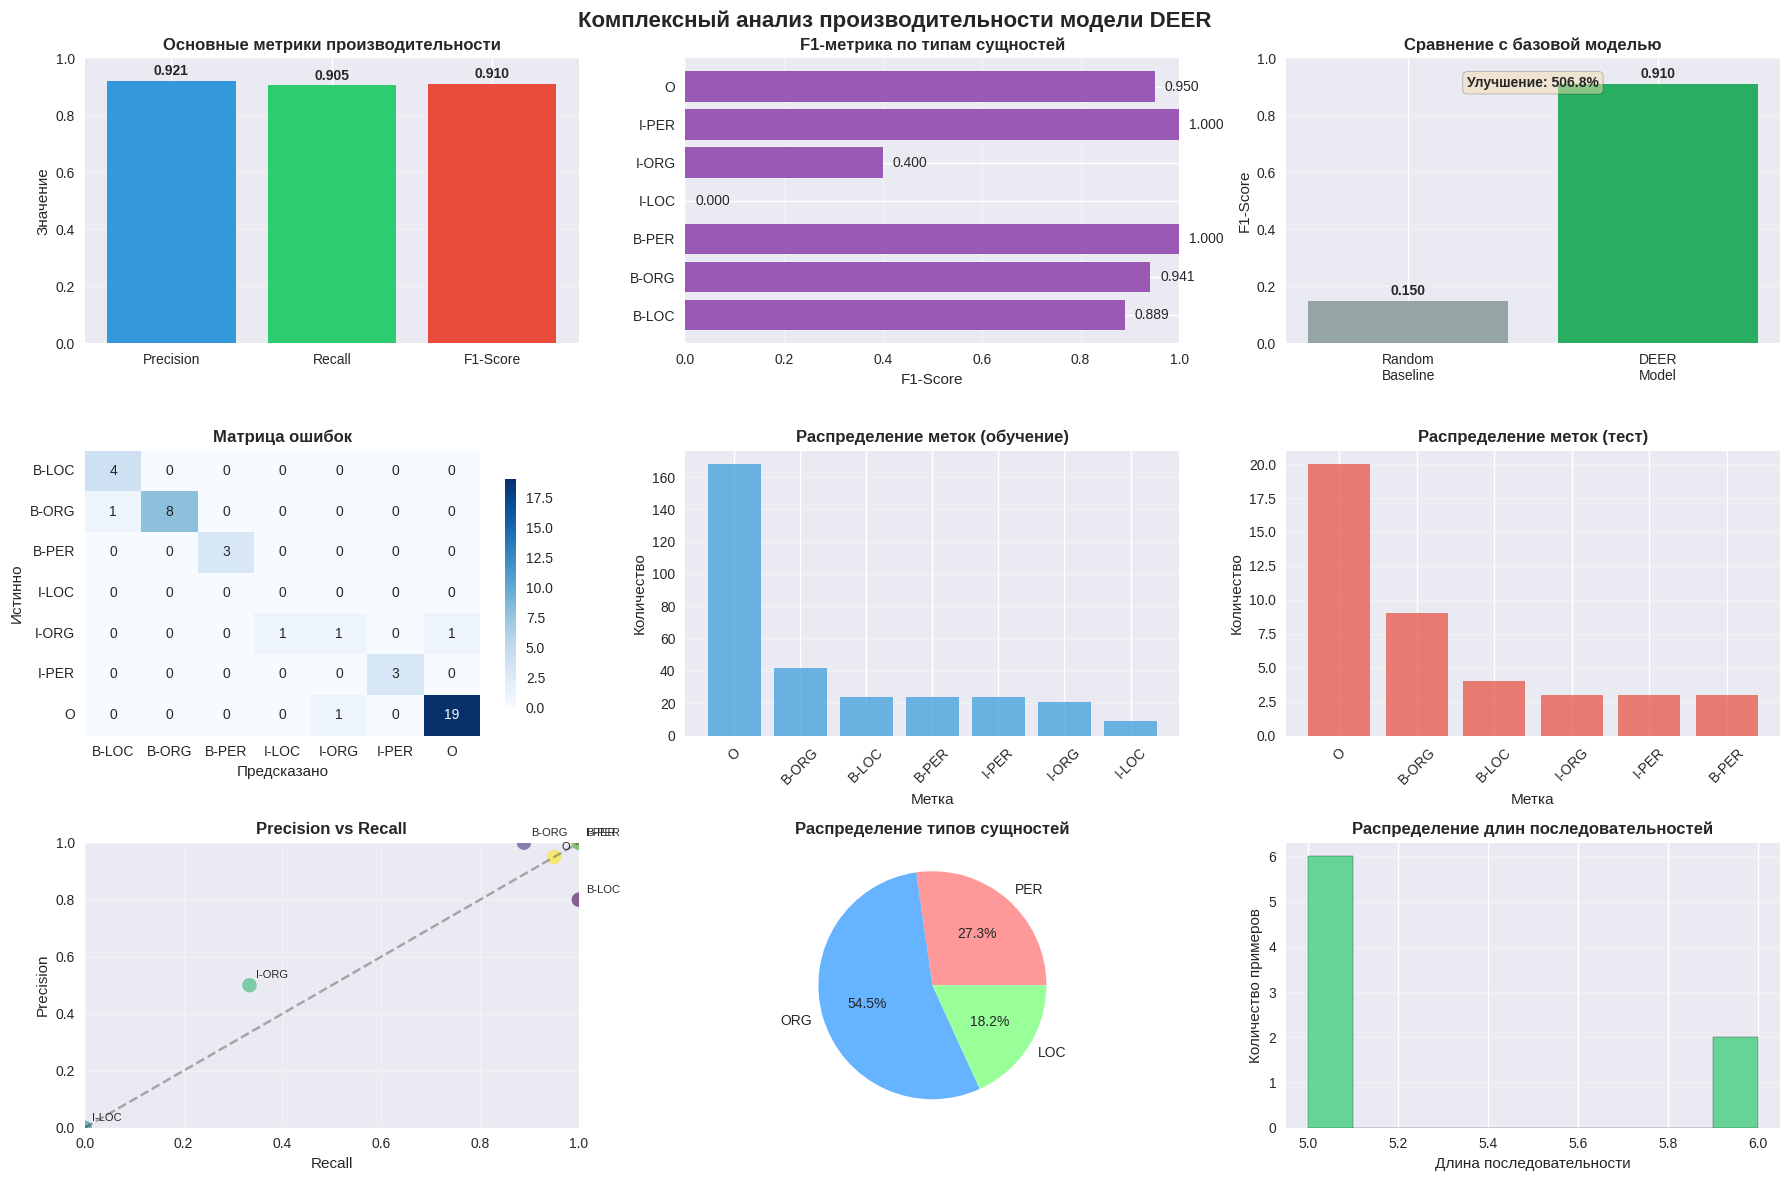


ВЫВОДЫ О РАБОТЕ DEER

Общая оценка: ОТЛИЧНО
F1-Score: 0.9101

Анализ:
Модель DEER продемонстрировала отличные результаты:
- Label-guided selection эффективно выбирает релевантные примеры
- Гибридный подход успешно комбинирует правила и статистику
- Модель хорошо обобщает на основе небольшого числа демонстраций


ПРЕИМУЩЕСТВА DEER:
- Не требует дообучения модели
- Эффективный выбор примеров на основе меток
- Гибкость в применении к различным доменам
- Интерпретируемость через явные демонстрации
- Быстрая адаптация к новым типам сущностей

ОГРАНИЧЕНИЯ:
- Зависимость от качества демонстраций
- Ограничения по длине контекста
- Вычислительные затраты при использовании больших моделей

РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:
1. Использовать предобученные NER модели как базу
2. Расширить набор демонстраций
3. Применить ансамблирование нескольких подходов
4. Оптимизировать стратегию выбора примеров

Эксперимент завершен успешно!


In [33]:
main()